# Train 데이터를 지나치게 너무 많이 학습하여 과대적합이 발생한다.
### Dropout: 이를 조금 덜 학습하게, 일부 node를 끊어버리는 것
    - 이를 앙상블의 일종이라고도 한다: 왜냐하면, 각 Epoch마다 다른 Node를 끊어 서로 다른 패턴들을 학습하기 때문
    - 파라미터 구성: layers.Dropout(rate=0.3) (여기서 rate는 weight의 기준이 아닌 node기준! node를 그냥 꺼버림)
      - 이는 epoch마다 다른 node를 off
    - Learning Curve를 봤을 때, train과 valid가 거의 유사. 이는 학습에 있어 일반화적인 성능을 학습하고 있다고 해석 가능
      
### BatchNormalization: 각 batch 마다 정규화를 한 번 더 실시

    - Batch가 모델에 들어올 때, Train data 전체에 대해 정규화를 했음에도, 일부 배치만 떼어 가져온다면, 이는 정규화된 수치를 어기게됨
    - 즉, 정작 정규화를 했어도, 각 배치마다 들어오는 것은 정규화가 이루어지지 않은 상태 (스케일이 맞지 않음)
    - 이는 결국 "일반화" 적인 특성을 왜곡한 것. --> 더욱 일반화 성능을 대변하기 위해 Batch정규화를 실시한다.
    - 이는 Train Epoch를 더 줄이는 장점이 있으며(학습속도 up), 학습을 잘 할 수 있다는 특징을 가지고있다.
    - layers.BatchNormalization() = sklearn StandardScaler

### 중요사항 추가
    - 학습 전에, Train data에 대한 전체적인 Scaling을 꼭 실시하라!!

### 정리:
    - Dropout: Ovefitting방지
    - BatchNormalization: 학습속도를 빠르게
    

# 구현

In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Dropout에 대한 성능비교
 - Train loss와 Valid loss가 비슷하다는 것은 Train 데이터가 더욱 학습하는 동안 일반화적인 성능을 학습한다는 것

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('./data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Minimum Validation Loss: 0.1884


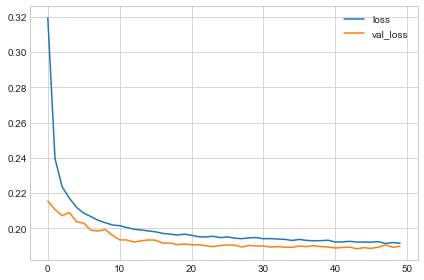

In [4]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# BatchNormalization에 대한 성능 비교
 - Loss: nan --> 4.0002 (정규화의 효과)

### without Batchnormalization

Minimum Validation Loss: nan


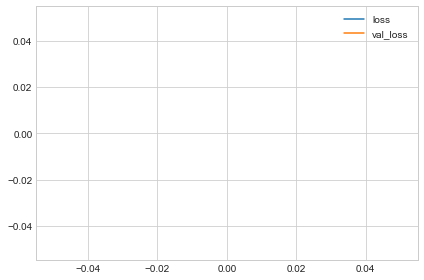

In [7]:
import pandas as pd

concrete = pd.read_csv('./data/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

### with BatchNormalization

Minimum Validation Loss: 4.0002


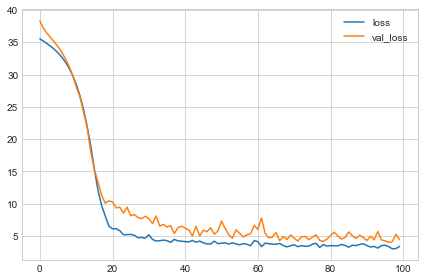

In [9]:
# YOUR CODE HERE: Add a BatchNormalization layer before each Dense layer
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))